In [1]:
using LinearAlgebra, Interpolations, PyPlot, Roots

# Lecture 1

## Discretizing State Space

In [2]:
function discretize_assets(amin, amax, n_a)
    # find maximum ubar of uniform grid corresponding to desired maximum amax of asset grid
    ubar = log(1 + log(1 + amax - amin))
    
    # make uniform grid
    u_grid = LinRange(0, ubar, n_a)
    
    # double-exponentiate uniform grid and add amin to get grid from amin to amax
    return amin .+ exp.(exp.(u_grid) .- 1) .- 1
end;

In [3]:
a_grid = discretize_assets(0, 10000, 50)
println(a_grid)

[0.0, 0.04975698153883745, 0.10459121897869572, 0.16516698552593123, 0.23225521534472748, 0.3067537111300265, 0.3897117511542112, 0.4823601769936814, 0.5861483391931348, 0.7027896635934308, 0.8343181054864399, 0.9831584223402379, 1.1522140734804123, 1.3449777223392694, 1.5656708781724533, 1.819421314931303, 2.112489749031087, 2.45256113243738, 2.849121230856714, 3.313946492379256, 3.8617454102026834, 4.511003863921974, 5.285107071473439, 6.213839428738549, 7.335404566805112, 8.699167281976308, 10.369405461979012, 12.430487287520858, 14.994077707040866, 18.209260957905087, 22.276893834417972, 27.470158678107037, 34.164296136992995, 42.88007756999174, 54.348074039710276, 69.60477308493755, 90.13806331334723, 118.11021936814082, 156.70416519662206, 210.66854429224318, 287.18801919428455, 397.29360849547504, 558.1837984762485, 797.1067906665255, 1157.9643094241846, 1712.7444670937211, 2581.6825353699523, 3969.502746739219, 6231.89053821472, 9999.99999999999]


In [4]:
function rouwenhorst_Pi(N, p)
    # base case Pi_2
    Pi = [p 1 - p; 1 - p p]
    
    # recursion to build up from Pi_2 to Pi_N
    for n in 3:N
        Pi_old = Pi
        Pi = zeros(n, n)
        
        Pi[1:end-1, 1:end-1] .+= p .* Pi_old
        Pi[1:end-1, 2:end] .+= (1 - p) .* Pi_old
        Pi[2:end, 1:end-1] .+= (1 - p) .* Pi_old
        Pi[2:end, 2:end] .+= p .* Pi_old
        Pi[2:end-1, :] ./= 2
    end
    
    return Pi
end;

In [5]:
function stationary_markov(Pi, tol=1E-14)
    # start with uniform distribution over all states
    n = size(Pi, 1)
    pi = fill(1/n, n)
    
    # update distribution using Pi until successive iterations differ by less than tol
    for _ in 1:10000
        pi_new = Pi' * pi
        if maximum(abs.(pi_new - pi)) < tol
            return pi_new
        end
        pi = pi_new
    end
end;

In [6]:
function discretize_income(rho, sigma, n_e)
    # choose inner-switching probability p to match persistence rho
    p = (1 + rho) / 2
    
    # start with states from 0 to n_e-1, scale by alpha to match standard deviation sigma
    e = collect(0:n_e-1)
    alpha = 2 * sigma / sqrt(n_e - 1)
    e = alpha .* e
    
    # obtain Markov transition matrix Pi and its stationary distribution
    Pi = rouwenhorst_Pi(n_e, p)
    pi = stationary_markov(Pi)
    
    # e is log income, get income y and scale so that mean is 1
    y = exp.(e)
    y /= dot(pi, y)
    
    return y, pi, Pi
end;

In [7]:
y, pi, Pi = discretize_income(0.975, 0.7, 7)
y, pi

([0.14136939855541714, 0.2503660179912723, 0.44339965795521247, 0.7852633446510819, 1.3907059001720974, 2.462948148474766, 4.3618953377019585], [0.015625000000046425, 0.09375000000009327, 0.2343749999999553, 0.31249999999981654, 0.2343749999999553, 0.09375000000009326, 0.015625000000046414])

In [8]:
dot(pi, y)

0.9999999999999999

In [9]:
mean_log_y = dot(pi, log.(y))
sd_log_y = sqrt(dot(pi, (log.(y) .- mean_log_y).^2))
sd_log_y

0.7000000000003483

## Backward Iteration to Obtain the Policy Function

In [10]:
function backward_iteration(Va, Pi, a_grid, y, r, beta, eis)
    # step 1: discounting and expectations
    Wa = (beta * Pi) * Va

    # step 2: solving for asset policy using the first-order condition
    c_endog = Wa .^ (-eis)
    coh = y .+ (1 .+ float(r)) .* a_grid'

    a = similar(coh, eltype(coh))
    for s in 1:length(y)
        interp = LinearInterpolation(a_grid .+ c_endog[s, :], a_grid, extrapolation_bc=Flat())
        a[s, :] = interp(coh[s, :])
    end

    # step 3: enforcing the borrowing constraint and backing out consumption
    a = max.(a, a_grid[1])
    c = coh .- a

    # step 4: using the envelope condition to recover the derivative of the value function
    Va = (1 .+ float(r)) .* c .^ (-1/eis)

    return Va, a, c
end;

In [11]:
function policy_ss(Pi, a_grid, y, r, beta, eis, tol=1E-9)
    # initial guess for Va: assume consumption 5% of cash-on-hand, then get Va from envelope condition
    coh = y .+ (1 + r) .* a_grid'
    c = 0.05 .* coh
    Va = (1 + r) .* c .^ (-1 / eis)
    
    # iterate until maximum distance between two iterations falls below tol, fail-safe max of 10,000 iterations
    a_old = similar(coh, eltype(coh))
    
    for it in 1:10_000
        Va, a, c = backward_iteration(Va, Pi, a_grid, y, r, beta, eis)
        
        # after iteration 0, can compare new policy function to old one
        if it > 1 && maximum(abs.(a .- a_old)) < tol
            return Va, a, c
        end
        
        copyto!(a_old, a)
    end
    
    error("Did not converge within the maximum number of iterations.")
end;

In [12]:
a_grid = discretize_assets(0, 10000, 500)
y, pi, Pi = discretize_income(0.975, 0.7, 7);

In [13]:
r = 0.01/4
beta = 1-0.08/4
eis = 1;

In [14]:
# # Making sure backward_iteration works
# coh = y .+ (1 + r) .* a_grid'
# c = 0.05 .* coh
# Va = (1 + r) .* c .^ (-1 / eis)
# backward_iteration(Va, Pi, a_grid, y, r, beta, eis)

In [15]:
Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis);

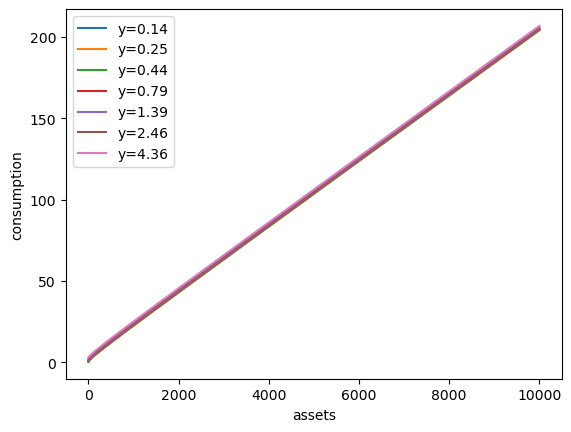

In [16]:
for (s, ys) in enumerate(y)
    plot(a_grid, c[s, :], label = "y=$(round(ys, digits = 2))")
end

legend()
xlabel("assets")
ylabel("consumption");

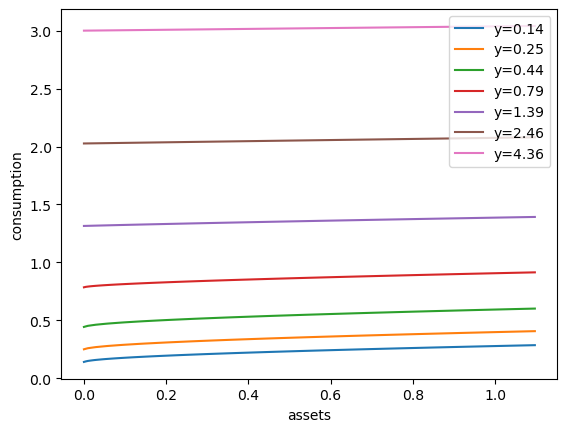

In [17]:
for (s, ys) in enumerate(y)
    plot(a_grid[1:120], c[s, 1:120], label="y=$(round(ys, digits=2))")
end

legend()
xlabel("assets")
ylabel("consumption");

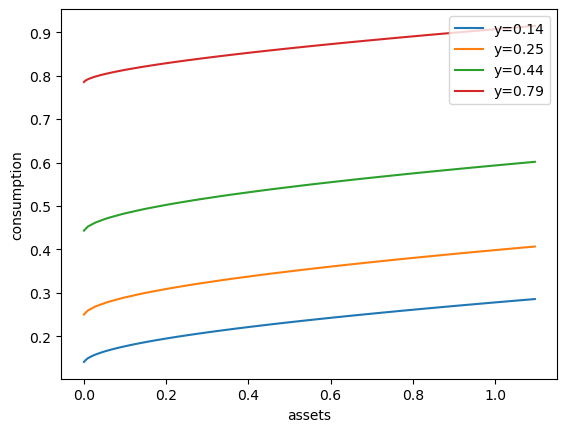

In [18]:
for (s, ys) in enumerate(y[1:4])
    plot(a_grid[1:120], c[s, 1:120], label="y=$(round(ys, digits=2))")
end

legend()
xlabel("assets")
ylabel("consumption");

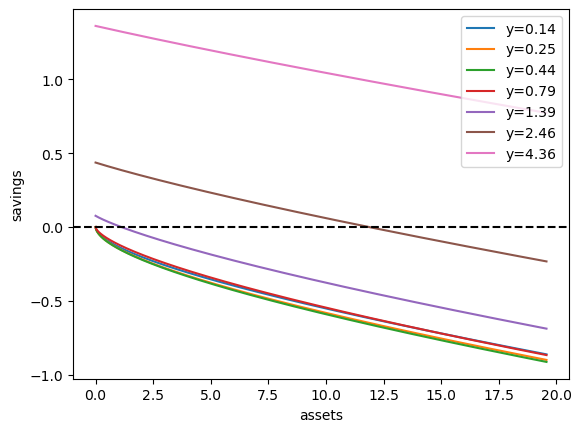

In [19]:
for (s, ys) in enumerate(y)
    plot(a_grid[1:300], a[s, 1:300] .- a_grid[1:300], label="y=$(round(ys, digits=2))")
end

axhline(0, linestyle="--", color="k")
legend()
xlabel("assets")
ylabel("savings");

## Forward Iteration to Obtain the Distribution

In [20]:
a[6, 1]

0.43644603651957603

In [21]:
a_grid[61:70]

10-element Vector{Float64}:
 0.38029037661676024
 0.38883466890388885
 0.3974720996665688
 0.4062039362429042
 0.4150314664925947
 0.42395599917844606
 0.43297886435583166
 0.44210141377029566
 0.4513250212634763
 0.4606510831875472

In [22]:
function get_lottery_helper(a, a_grid)
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = searchsortedfirst(a_grid, a) - 1 # NOTE: a_i is going to be +1 of what it would be in Python
    
    # step 2: obtain lottery probabilities pi
    if a_i == 0
        a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[end])
    else
        a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    end
    
    return a_i, a_pi
end;

In [23]:
get_lottery_helper(a[6,1], a_grid)

(67, 0.6199338577166714)

In [24]:
function get_lottery(a, a_grid)
    a_i = similar(a, eltype(a))
    a_pi = similar(a, eltype(a))
    for row in 1:size(a, 1) 
        for column in 1:size(a, 2)
            a_i_helper, a_pi_helper = get_lottery_helper(a[row, column], a_grid)
            a_i[row, column] = a_i_helper
            a_pi[row, column] = a_pi_helper
        end
    end
    return Int.(a_i), a_pi
end;

In [25]:
# # Making sure get_lottery works
# a_i, a_pi = get_lottery(a, a_grid)
# print(a_i)
# print(a_pi)

In [26]:
a_i, a_pi = get_lottery(a, a_grid)
size(a_i), eltype(a_i), size(a_pi), eltype(a_pi)

((7, 500), Int64, (7, 500), Float64)

In [27]:
function forward_policy(D, a_i, a_pi)
    Dend = zeros(size(D))
    for e in 1:size(a_i, 1)
        for a in 1:size(a_i, 2)
            # send pi(e,a) of the mass to gridpoint i(e,a)
            if a_i[e, a] == 0
                Dend[e, end] += a_pi[e, a] * D[e, a]
            else
                Dend[e, a_i[e, a]] += a_pi[e, a] * D[e, a]
            end
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e, a]+1] += (1 - a_pi[e, a]) * D[e, a]
        end
    end
    
    return Dend
end;

In [28]:
function forward_iteration(D, Pi, a_i, a_pi)
    Dend = forward_policy(D, a_i, a_pi)
    return transpose(Pi) * Dend
end;

In [29]:
function distribution_ss(Pi, a, a_grid, tol=1e-10)
    a_i, a_pi = get_lottery(a, a_grid)
    
    # as initial D, use stationary distribution for e, plus uniform over a
    pi = stationary_markov(Pi)
    D = (pi / length(a_grid)) .* ones(size(a))
    
    # now iterate until convergence to acceptable threshold
    for _ in 1:10000
        D_new = forward_iteration(D, Pi, a_i, a_pi)
        if maximum(abs.(D_new .- D)) < tol
            return D_new
        end
        D = D_new
    end
    
    error("Did not converge within the maximum number of iterations.")
end;

In [30]:
D = distribution_ss(Pi, a, a_grid)
size(D)

(7, 500)

## Aggregating to Full Steady State

In [31]:
# function steady_state(Pi, a_grid, y, r, beta, eis)
#     Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis)
#     D = distribution_ss(Pi, a, a_grid)
    
#     return Dict("D" => D, "Va" => Va, 
#                 "a" => a, "c" => c,
#                 "A" => dot(a, D), "C" => dot(c, D), # aggregation
#                 "Pi" => Pi, "a_grid" => a_grid, "y" => y, "r" => r, "beta" => beta, "eis" => eis)
# end;

In [32]:
function steady_state(Pi, a_grid, y, r, beta, eis)
    Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis)
    a_i, a_pi = get_lottery(a, a_grid)
    D = distribution_ss(Pi, a, a_grid)
    
    return Dict("D" => D, "Va" => Va, 
                "a" => a, "c" => c, "a_i" => a_i, "a_pi" => a_pi,
                "A" => dot(a, D), "C" => dot(c, D),
                "Pi" => Pi, "a_grid" => a_grid, "y" => y, "r" => r, "beta" => beta, "eis" => eis)
end;

In [33]:
ss = steady_state(Pi, a_grid, y, r, beta, eis)
keys(ss)

KeySet for a Dict{String, Any} with 14 entries. Keys:
  "a_pi"
  "c"
  "C"
  "a_i"
  "a_grid"
  "r"
  "a"
  "eis"
  "y"
  "A"
  "D"
  "Va"
  "beta"
  "Pi"

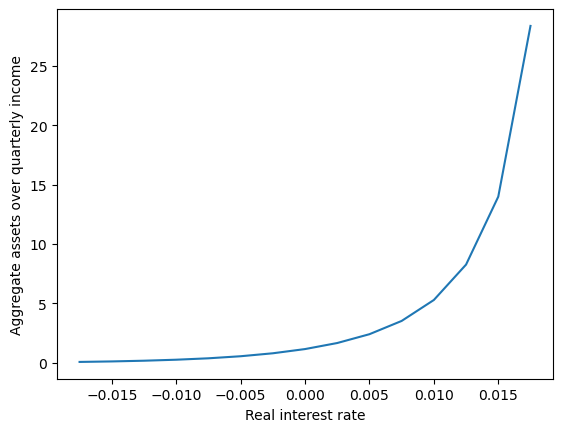

In [34]:
rs = r .+ LinRange(-0.02, 0.015, 15)
As = [steady_state(Pi, a_grid, y, r, beta, eis)["A"] for r in rs]
plot(rs, As)
xlabel("Real interest rate")
ylabel("Aggregate assets over quarterly income");

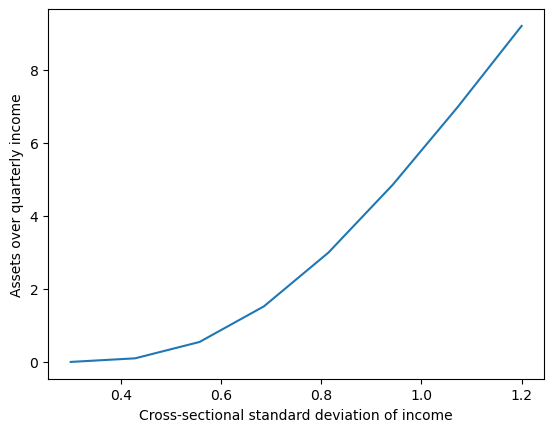

In [35]:
sigmas = range(0.3, 1.2, length=8) # our benchmark was sigma=0.7
As = Float64[]

for sigma in sigmas
    y_new, pi_new, Pi_new = discretize_income(0.975, sigma, 7)
    push!(As, steady_state(Pi_new, a_grid, y_new, r, beta, eis)["A"])
end

plot(sigmas, As)
xlabel("Cross-sectional standard deviation of income")
ylabel("Assets over quarterly income");

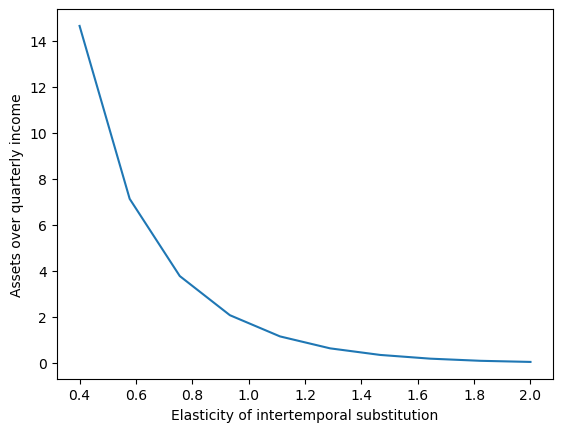

In [36]:
eis_vec = range(0.4, 2, length=10) # our benchmark was eis=1
As = [steady_state(Pi, a_grid, y, r, beta, eis)["A"] for eis in eis_vec]
plot(eis_vec, As)
xlabel("Elasticity of intertemporal substitution")
ylabel("Assets over quarterly income");

## Expectation Functions

In [37]:
function expectation_policy(Xend, a_i, a_pi)
    X = zeros(size(Xend))
    for e in 1:size(a_i, 1)
        for a in 1:size(a_i, 2)
            if a_i[e, a] == 0
                X[e, a] = a_pi[e, a] * Xend[e, end] + (1 - a_pi[e, a]) * Xend[e, a_i[e, a] + 1]
            else
                # expectation is pi(e,a) * Xend(e,i(e,a)) + (1-pi(e,a))*Xend(e,i(e,a)+1)
                X[e, a] = a_pi[e, a] * Xend[e, a_i[e, a]] + (1 - a_pi[e, a]) * Xend[e, a_i[e, a] + 1]
            end
        end
    end

    return X
end;

In [38]:
function expectation_iteration(X, Pi, a_i, a_pi)
    Xend = Pi * X
    return expectation_policy(Xend, a_i, a_pi)
end;

In [39]:
function expectation_functions(X, Pi, a_i, a_pi, T)
    # set up array of curlyEs and fill in first row with base case
    curlyE = Array{Float64}(undef, T, size(X, 1), size(X, 2))
    curlyE[1, :, :] = X
    
    # recursively apply the law of iterated expectations
    for j in 2:T
        curlyE[j, :, :] = expectation_iteration(curlyE[j-1, :, :], Pi, a_i, a_pi)
    end
    
    return curlyE
end;

In [40]:
T = 40
ctilde = c .- dot(D, c) # demeaned consumption
E_ctilde = expectation_functions(ctilde, Pi, a_i, a_pi, T); # expectation functions for 0, ... , T-1

In [41]:
Autocov_c = zeros(T)
for j in 1:T
    Autocov_c[j] = dot(D, ctilde .* E_ctilde[j, :, :])
end

In [42]:
Autocorr_c = Autocov_c / Autocov_c[1];

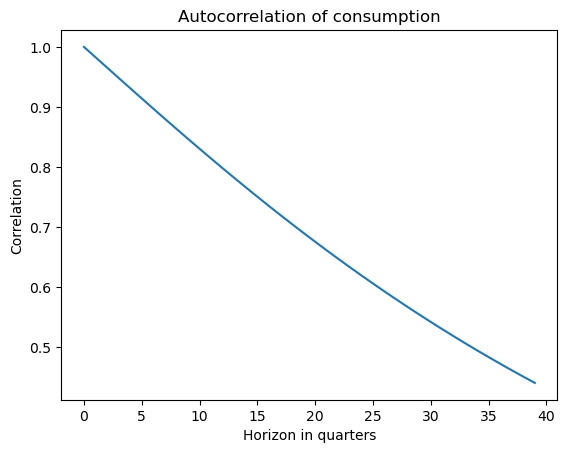

In [43]:
plot(Autocorr_c)
title("Autocorrelation of consumption")
xlabel("Horizon in quarters")
ylabel("Correlation");

# Lecture 2 and 3

In [44]:
T = 11 # we'll calculate household responses up to T
ys = transpose((1 .+ 0.01 .* (collect(0:T-1)' .== 5)) .* ss["y"]);

In [45]:
Va = ss["Va"] # initialize with steady-state marginal value function
a = Array{Float64}(undef, T, size(ss["a"], 1), size(ss["a"], 2)) # empty arrays to store a and c paths
c = Array{Float64}(undef, T, size(ss["a"], 1), size(ss["a"], 2))
ss_inputs = Dict(k => ss[k] for k in ("Pi", "a_grid", "r", "beta", "eis")) # dict of non-changing ss inputs
for t in reverse(1:T)
    Va, a[t, :, :], c[t, :, :] = backward_iteration(Va, ss_inputs["Pi"], ss_inputs["a_grid"], ys[t, :], ss_inputs["r"], 
                                                    ss_inputs["beta"], ss_inputs["eis"])
end

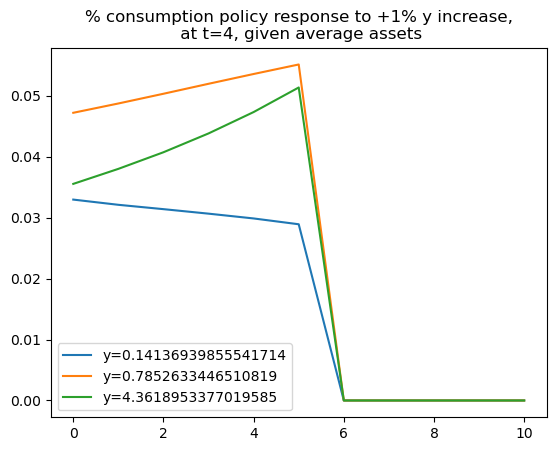

In [46]:
c_impulse = Array{Float64}(undef, T, size(ss["a"], 1), size(ss["a"], 2))
for i in 1:T
    c_impulse[i, :, :] = 100 .* (c[i, :, :] .- ss["c"]) ./ ss["c"] # percent change in consumption policy function
end
i_ave = findfirst(x -> x > ss["A"], ss["a_grid"]) # first index of assets above average
for e in (1, 4, 7)
    plot(c_impulse[:, e, i_ave], label="y=$(ss["y"][e])")
end
legend()
title("% consumption policy response to +1% y increase,\n at t=4, given average assets");

In [47]:
D = zeros(size(a,1), size(a,2), size(a,3))
D[1, :, :] = ss["D"];

In [48]:
for t in 1:T-1
    a_i, a_pi = get_lottery(a[t, :, :], ss["a_grid"])
    
    D[t+1, :, :] = forward_iteration(D[t, :, :], ss["Pi"], a_i, a_pi)
end

In [49]:
A = zeros(T)
C = zeros(T)
for t in 1:T
    A[t] = dot(D[t, :, :], a[t, :, :])
    C[t] = dot(D[t, :, :], c[t, :, :])
end

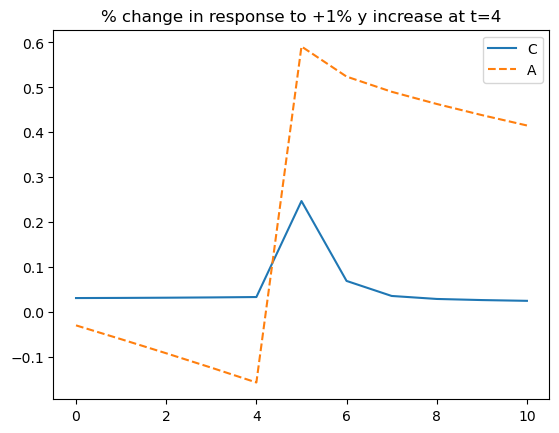

In [50]:
C_impulse = 100*(C .- ss["C"])./ss["C"]
A_impulse = 100*(A .- ss["A"])./ss["C"]
plot(C_impulse, label="C")
plot(A_impulse, "--", label="A")
legend()
title("% change in response to +1% y increase at t=4");

In [51]:
function policy_impulse(ss, shocks, T)
    # check that all values in "shocks" have first dimension T
    @assert all(size(x,1) == T for x in values(shocks))

    # extract inputs to backward_iteration function from ss
    inputs = Dict(k => ss[k] for k in ("Va", "Pi", "a_grid", "y", "r", "beta", "eis"))

    # create a T*nS*nA array to store each output of backward iteration
    Va = Array{Float64}(undef, T, size(ss["Va"], 1), size(ss["Va"], 2))
    a = Array{Float64}(undef, T, size(ss["Va"], 1), size(ss["Va"], 2))
    c = Array{Float64}(undef, T, size(ss["Va"], 1), size(ss["Va"], 2))

    for t in reverse(1:T)
        # add this period's perturbation to parameters that are shocked
        for k in ("y", "r", "beta")
            if k in keys(shocks)
                inputs[k] = ss[k] .+ shocks[k][t, :]
            end
        end

        Va[t, :, :], a[t, :, :], c[t, :, :] = backward_iteration(inputs["Va"], inputs["Pi"], inputs["a_grid"], inputs["y"], 
                                                                 inputs["r"], inputs["beta"], inputs["eis"])

        # use this Va for the next iteration
        inputs["Va"] = Va[t, :, :]
    end

    return Va, a, c
end;

In [52]:
y_dict = zeros(size(ys,1), size(ys, 2))
for i in 1:T
    y_dict[i, :] = ys[i, :] - ss["y"]
end
y_dict

_, a_alt, c_alt = policy_impulse(ss, Dict("y" => y_dict), T)
@assert all(a .== a_alt) && all(c .== c_alt)

In [53]:
function distribution_impulse(ss, a, T)
    @assert size(a, 1) == T
    D = similar(a)
    D[1, :, :] = ss["D"]
    
    for t in 1:T-1
        a_i, a_pi = get_lottery(a[t, :, :], ss["a_grid"])
        D[t+1, :, :] = forward_iteration(D[t, :, :], ss["Pi"], a_i, a_pi)
    end
    
    return D
end;

In [54]:
function household_impulse(ss, shocks, T)
    Va, a, c = policy_impulse(ss, shocks, T)
    D = distribution_impulse(ss, a, T)
    return Dict("D" => D, "Va" => Va, "a" => a, "c" => c, # time-varying stuff
                "A" => vec(sum(a.*D, dims=(2,3))), "C" => vec(sum(c.*D, dims=(2,3)))) # aggregate everything else quickly
end;

In [55]:
y_dict = zeros(size(ys,1), size(ys,2))
for i in 1:T
    y_dict[i, :] = ys[i, :] - ss["y"]
end
y_dict

impulse = household_impulse(ss, Dict("y" => y_dict), T);

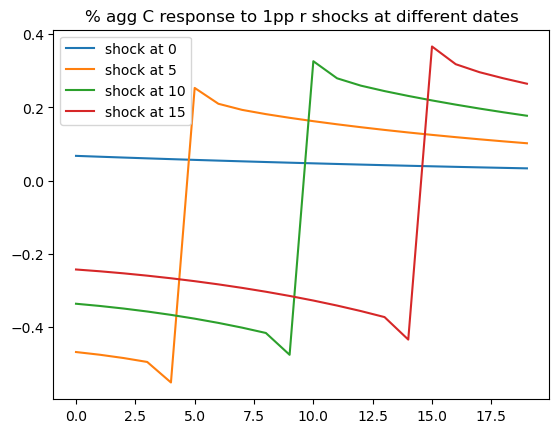

In [56]:
for t in (0, 5, 10, 15)
    impulse = 0.01 .* (collect(0:19) .== t)
    C_response = household_impulse(ss, Dict("r" => impulse), 20)["C"] .- ss["C"]
    C_percentage = 100 * C_response / ss["C"]
    label_text = "shock at $t"
    plot(C_percentage, label=label_text)
end
legend()
title("% agg C response to 1pp r shocks at different dates");

In [57]:
B = 5.6
tau = ss["r"] * B
e = ss["y"]
beta_ge = 0.9877855433151485;

In [58]:
# # Define the function to be optimized
# function objective_function(beta)
#     result = steady_state(ss["Pi"], ss["a_grid"], (1 - tau) * e, ss["r"], beta, ss["eis"])["A"] - B
#     return result
# end

# # Find the root using find_zero with the Bisection method
# beta_ge = find_zero(objective_function, (0.98, 0.995), Bisection())

In [59]:
ss_ge = steady_state(ss["Pi"], ss["a_grid"], (1 - tau) * e, ss["r"], beta_ge, ss["eis"])
ss_ge["A"] - B # check asset market clearing

-1.660094284261504e-11

In [60]:
T = 300
Xs = [1 + 0.01 * 0.95^t for t in 0:T-1];

In [61]:
pi = sum(ss_ge["D"], dims=2) # steady-state distribution of s (unchanging)

function impulse_map(rs, Xs)
    # government budget balance at each date: tau_t = r_t*B (given average e=1)
    taus = rs .* B
    ys = (Xs .- taus) * e'
    
    y_dict = zeros(size(ys,1), size(ys,2))
    for i in 1:T
        y_dict[i, :] = ys[i, :] - ss_ge["y"]
    end
    y_dict
    
    # calculate household impulse
    impulse = household_impulse(ss_ge, Dict("r" => rs .- ss_ge["r"], "y" => y_dict), length(rs))
    
    return impulse["A"] .- B, impulse
end;

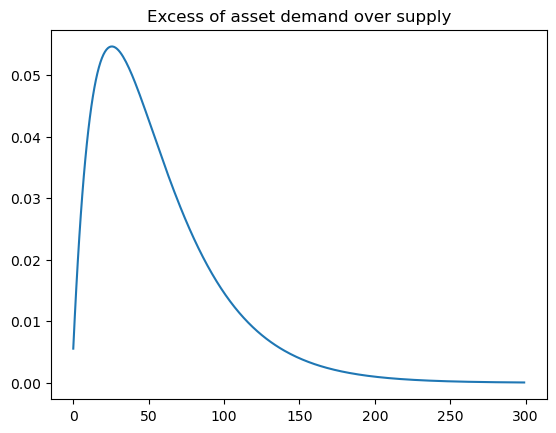

In [62]:
asset_mkt_error, _ = impulse_map(fill(ss_ge["r"], T), Xs)
plot(asset_mkt_error)
title("Excess of asset demand over supply");

Converged to 0.0005 accuracy after 138 iterations


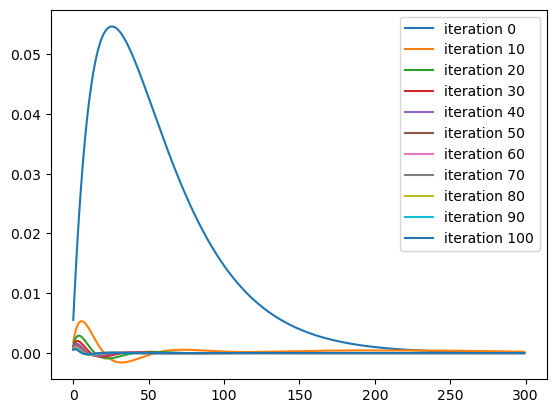

In [63]:
rs = fill(ss_ge["r"], T) # initial guess constant
for it in 0:399
    asset_mkt_error, impulse = impulse_map(rs, Xs)
    if it % 10 == 0 && it <= 100
        plot(asset_mkt_error, label="iteration $it")
    end
    if maximum(abs.(asset_mkt_error)) < 5E-4
        println("Converged to 0.0005 accuracy after $it iterations")
        break
    end
    rs[2:end] .-= 0.002 .* asset_mkt_error[1:end-1] # remember: can't change rs[1], which was fixed here before date 0
end
legend();

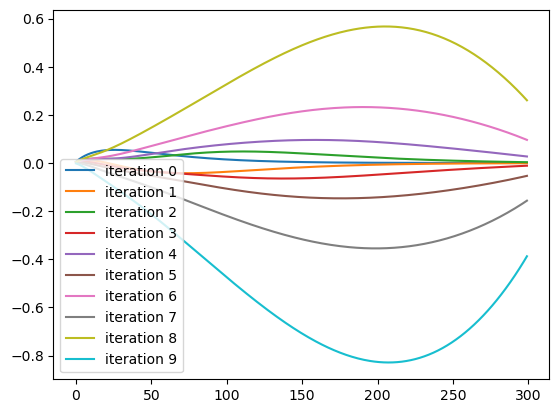

In [64]:
rs = fill(ss_ge["r"], T) # initial guess constant
for it in 0:9
    asset_mkt_error, impulse = impulse_map(rs, Xs)
    plot(asset_mkt_error, label="iteration $it")
    rs[2:end] .-= 0.003 .* asset_mkt_error[1:end-1]
end
legend();

## Brute-force ("direct") method to obtain sequence-space Jacobians

In [65]:
@time begin
    J = zeros(T, T)
    h = 1E-4
    no_shock = impulse_map(fill(ss_ge["r"], T), 1)[1]
    for tshock in 1:T
        J[:, tshock] = (impulse_map(ss_ge["r"] .+ h .* (collect(1:T) .== tshock), 1)[1] - no_shock) / h
    end
end

 40.388121 seconds (17.68 M allocations: 68.749 GiB, 5.77% gc time, 0.35% compilation time)


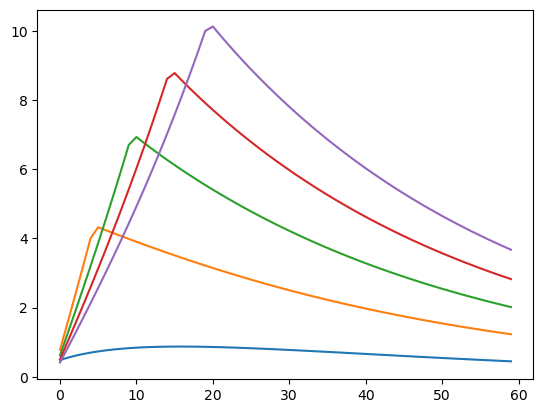

In [66]:
plot(J[1:60, [1, 6, 11, 16, 21]]);

## Using this Jacobian to update guesses

Asset market clearing up to 12 digits after 6 iterations


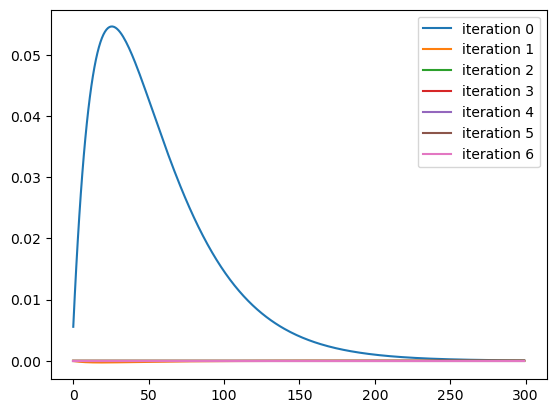

In [67]:
rs = fill(ss_ge["r"], T) # initial guess constant
Jbar = J[1:end-1, 2:end] # Jbar for our guesses eliminates last row and first column
errs = Float64[]
for it in 0:29
    asset_mkt_error, impulse = impulse_map(rs, Xs)
    plot(asset_mkt_error, label="iteration $it")
    err = maximum(abs.(asset_mkt_error[1:end-1])) # solve for asset market clearing at 0, 1, ..., T-2
    push!(errs, err)
    if err < 1E-10
        println("Asset market clearing up to 12 digits after $it iterations")
        break
    end
    rs[2:end] .-= Jbar \ asset_mkt_error[1:end-1] # adjust r_1, ..., r_(T-1)
end
legend();

## Speed of convergence

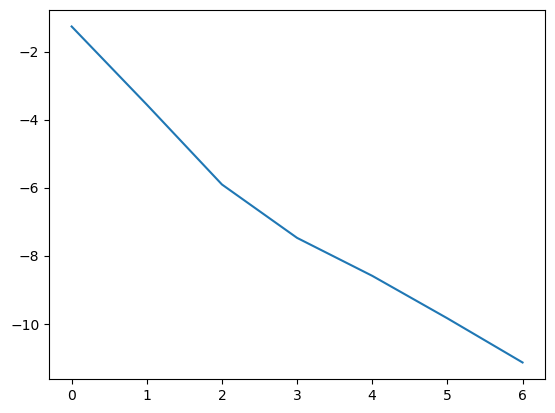

In [68]:
plot(log10.(errs));

## Resulting equilibrium path

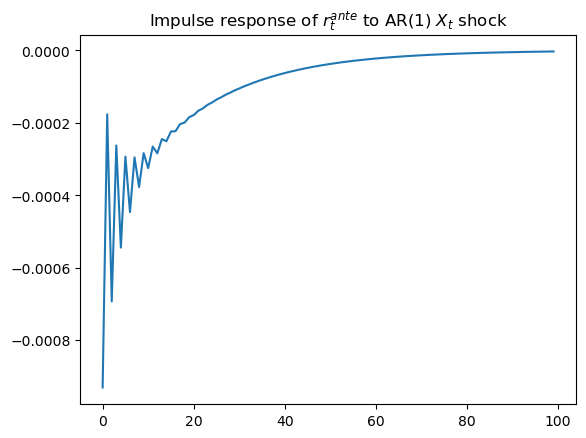

In [69]:
plot(rs[2:101] .- ss_ge["r"])
title("Impulse response of \$r_t^{ante}\$ to AR(1) \$X_t\$ shock");

## The "fake news algorithm" for sequence-space Jacobians

## Insight 1: symmetry in backward iteration

In [70]:
impulse_s4 = zeros(T, size(ss_ge["a"],1), size(ss_ge["a"],2))
impulse_s5 = zeros(T, size(ss_ge["a"],1), size(ss_ge["a"],2))
impulse_s6 = zeros(T, size(ss_ge["a"],1), size(ss_ge["a"],2));

for i in 1:T
    impulse_s4[i, :, :] = (impulse_map(ss_ge["r"] .+ h .* (collect(0:T-1) .== 4), 1)[2]["a"][i, :, :] .- ss_ge["a"]) ./ h
    impulse_s5[i, :, :] = (impulse_map(ss_ge["r"] .+ h .* (collect(0:T-1) .== 5), 1)[2]["a"][i, :, :] .- ss_ge["a"]) ./ h
    impulse_s6[i, :, :] = (impulse_map(ss_ge["r"] .+ h .* (collect(0:T-1) .== 6), 1)[2]["a"][i, :, :] .- ss_ge["a"]) ./ h
end

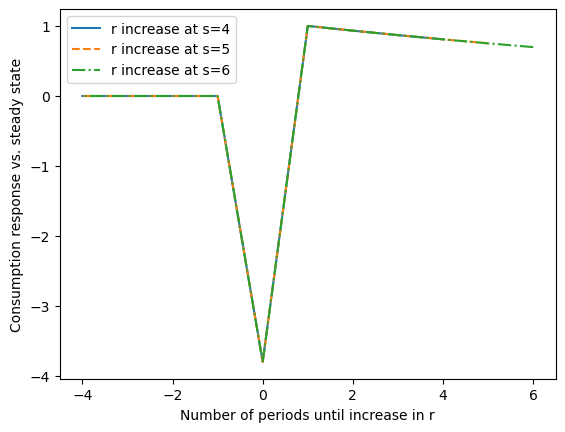

In [71]:
plt.plot(4:-1:-4, impulse_s4[1:9, 4, 51], label="r increase at s=4")
plt.plot(5:-1:-4, impulse_s5[1:10, 4, 51], "--", label="r increase at s=5")
plt.plot(6:-1:-4, impulse_s6[1:11, 4, 51], "-.", label="r increase at s=6")
plt.xlabel("Number of periods until increase in r")
plt.ylabel("Consumption response vs. steady state")
plt.legend();

## Use this to build Jacobian of `impulse_map`

In [72]:
@time begin
    da = zeros(T, size(ss_ge["a"],1), size(ss_ge["a"],2))
    for i in 1:T
        da[i, :, :] = impulse_map(ss_ge["r"] .+ h .* (collect(0:T-1) .== T-1), 1)[2]["a"][i, :, :] .- ss_ge["a"]
    end
end

 41.180771 seconds (17.27 M allocations: 68.921 GiB, 5.32% gc time, 0.07% compilation time)


In [73]:
@time begin
    J_alt = Array{Float64}(undef, T, T)
    
    a_ss = zeros(T, size(ss_ge["a"],1), size(ss_ge["a"],2))
    for i in 1:T
        a_ss[i, :, :] = ss_ge["a"]
    end
    
    for s in 0:T-1
        a = copy(a_ss)
        a[1:s+1, :, :] += da[T-s:end, :, :]
        D = distribution_impulse(ss_ge, a, T)
        A = sum(a .* D, dims = (2, 3))
        J_alt[:, s+1] = (A .- B .- no_shock) ./ h # NOTE: no_shock is slightly different from the Python version
    end
end

 12.279147 seconds (2.46 M allocations: 27.055 GiB, 4.21% gc time, 2.38% compilation time)


In [74]:
maximum(abs.(J_alt - J))

1.4210854715202004e-10

## Insight 2: difference between $J_{t,s}$ and $J_{t-1,s-1}$

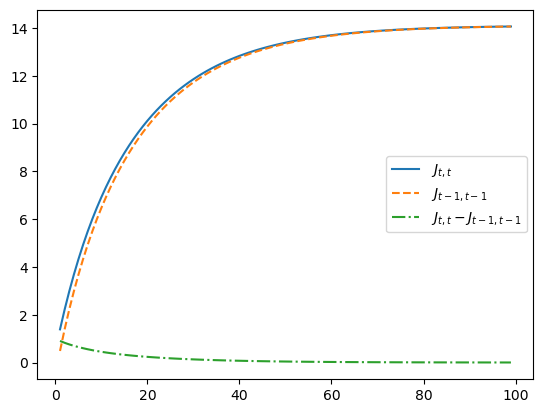

In [75]:
plt.plot(1:99, diag(J)[2:100], label="\$J_{t,t}\$")
plt.plot(1:99, diag(J)[1:99], "--", label="\$J_{t-1,t-1}\$")
plt.plot(1:99, diag(J)[2:100] - diag(J)[1:99], "-.", label="\$J_{t,t} - J_{t-1,t-1}\$")
plt.legend();

## Other way to see this: plotting columns of $J$

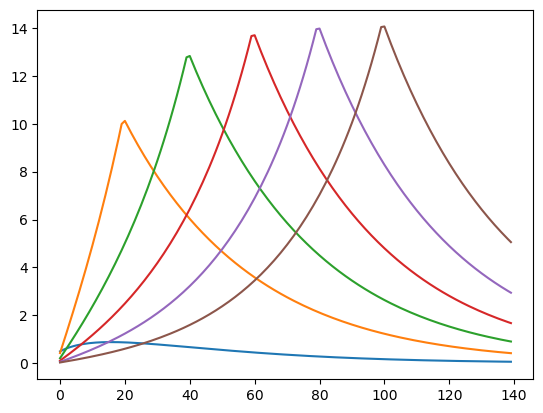

In [76]:
plt.plot(J[1:140, [1, 21, 41, 61, 81, 101]]);

## Insight 2 continued: $F_{t,s} \equiv J_{t,s} - J_{t-1,s-1}$ represents effect of anticipation

In [77]:
a = copy(a_ss)
a[1, :, :] += da[T-10, :, :] # only shock is to asset policy at date 0 from anticipating s=10 then, nothing else
D = distribution_impulse(ss_ge, a, T)
A = sum(a .* D, dims=(2, 3))
anticipation_effect = (A .- B .- no_shock) ./ h; # NOTE: seems to be same as Python version

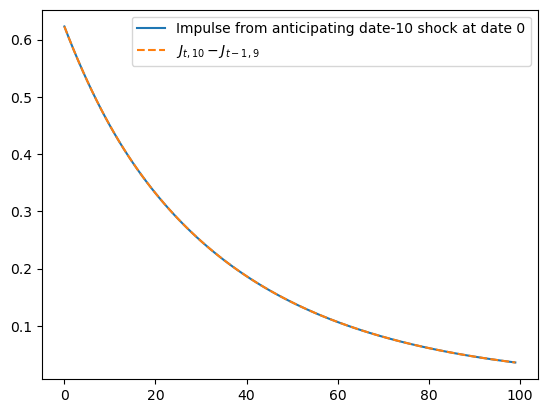

In [78]:
plt.plot(anticipation_effect[1:100], label="Impulse from anticipating date-10 shock at date 0")
F = copy(J)
F[2:end, 2:end] -= J[1:end-1, 1:end-1]
# NOTE: first element of F[1:100, 11] is slightly different from Python version
plt.plot(F[1:100, 11], linestyle="--", label=L"$J_{t, 10} - J_{t-1, 9}$") 
plt.legend();

## Calculating entire Jacobian using this insight

In [79]:
@time begin
    F_alt = zeros(T, T)
    for s in 0:T-1
        # calculate impulse response to anticipation of date-s shock at date 0
        a = copy(a_ss)
        a[1] += da[T-s]
        D = distribution_impulse(ss_ge, a, T)
        A = sum(a .* D, dims=(2, 3))
        F_alt[:, s+1] = (A .- B .- no_shock) ./ h
    end
    maximum(abs.(F_alt - F))
end

 11.384637 seconds (1.53 M allocations: 23.470 GiB, 4.68% gc time, 0.05% compilation time)


0.9537877476528678

In [80]:
function J_from_F(F)
    J = copy(F)
    for t in 1:size(F, 1)-1
        J[2:end, t+1] += J[1:end-1, t]
    end
    return J
end;

In [81]:
isequal(J_from_F(F), J)

true

## Insight 3: don't iterate on distribution, use expectation functions

In [82]:
@time begin
    curlyE = expectation_functions(ss_ge["a"], ss_ge["Pi"], ss_ge["a_i"], ss_ge["a_pi"], T)
end;

  0.010787 seconds (1.80 k allocations: 32.032 MiB)


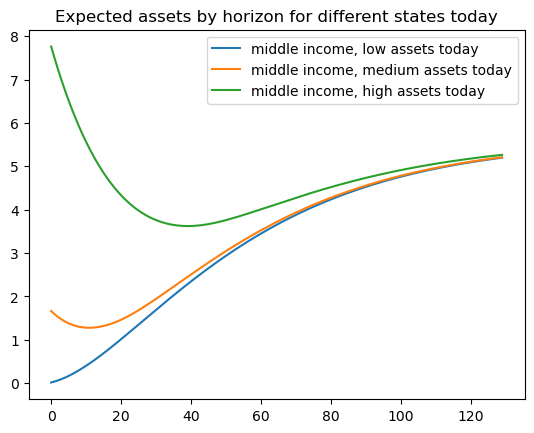

In [83]:
plt.plot(curlyE[1:130, 4, 1], label="middle income, low assets today")
plt.plot(curlyE[1:130, 4, 151], label="middle income, medium assets today")
plt.plot(curlyE[1:130, 4, 251], label="middle income, high assets today")
plt.title("Expected assets by horizon for different states today")
plt.legend();

## Full "fake news algorithm": build entire F matrix with this, get J

In [84]:
@time begin
    F = zeros(T, T)
    D1_noshock = forward_iteration(ss_ge["D"], ss_ge["Pi"], ss_ge["a_i"], ss_ge["a_pi"])
    for s in 0:T-1
        # F_(0,s): change in asset policy times steady-state incoming distribution
        F[1, s+1] = dot(ss_ge["D"], da[T-s, :, :]) / h

        # change in D_1 from this change
        a_i_shocked, a_pi_shocked = get_lottery(ss_ge["a"] + da[T-s, :, :], ss_ge["a_grid"])
        dD1 = forward_iteration(ss_ge["D"], ss_ge["Pi"], a_i_shocked, a_pi_shocked) - D1_noshock

        # use expectation vectors to project effect on aggregate
        F[2:end, s+1] = (reshape(curlyE[1:T-1, : , :], T-1, :) * vec(dD1)) / h
    end
    
    J_alt = J_from_F(F)
end;

  1.216041 seconds (38.10 k allocations: 2.416 GiB, 1.71% gc time, 2.07% compilation time)


In [85]:
maximum(abs.(J_alt - J))

0.0017242325524442492

## General code for step 1 for outputs $o \in a,c$, any input shock

In [86]:
function step1_backward(ss, shock, T, h)
    # preliminaries: D_1 with no shock, ss inputs to backward_iteration
    D1_noshock = forward_iteration(ss["D"], ss["Pi"], ss["a_i"], ss["a_pi"])
    ss_inputs = Dict(k => ss[k] for k in ("Va", "Pi", "a_grid", "y", "r", "beta", "eis"))
    
    # allocate space for results
    curlyY = Dict("A" => zeros(T), "C" => zeros(T))
    curlyD = zeros(T, size(ss["D"],1), size(ss["D"],2))
    
    # backward iterate
    Va = ss_inputs["Va"] # NOTE: need to initialize Va in Julia
    for s in 0:T-1
        if s == 0
            # at horizon of s=0, 'shock' actually hits, override ss_inputs with shock
            shocked_inputs = Dict(k => ss[k] + h*shock[k] for k in keys(shock))
            Va, a, c = backward_iteration(merge(ss_inputs, shocked_inputs)["Va"], 
                                          merge(ss_inputs, shocked_inputs)["Pi"], 
                                          merge(ss_inputs, shocked_inputs)["a_grid"], 
                                          merge(ss_inputs, shocked_inputs)["y"],
                                          merge(ss_inputs, shocked_inputs)["r"], 
                                          merge(ss_inputs, shocked_inputs)["beta"], 
                                          merge(ss_inputs, shocked_inputs)["eis"])
        else
            # now the only effect is anticipation, so it's just Va being different
            Va, a, c = backward_iteration(merge(ss_inputs, Dict("Va" => Va))["Va"], 
                                          merge(ss_inputs, Dict("Va" => Va))["Pi"], 
                                          merge(ss_inputs, Dict("Va" => Va))["a_grid"], 
                                          merge(ss_inputs, Dict("Va" => Va))["y"], 
                                          merge(ss_inputs, Dict("Va" => Va))["r"], 
                                          merge(ss_inputs, Dict("Va" => Va))["beta"], 
                                          merge(ss_inputs, Dict("Va" => Va))["eis"])
        end
        
        # aggregate effects on A and C
        curlyY["A"][s+1] = dot(ss["D"], a - ss["a"]) / h
        curlyY["C"][s+1] = dot(ss["D"], c - ss["c"]) / h
        
        # what is effect on one-period-ahead distribution?
        a_i_shocked, a_pi_shocked = get_lottery(a, ss["a_grid"])
        curlyD[s+1, :, :] = (forward_iteration(ss_ge["D"], ss_ge["Pi"], a_i_shocked, a_pi_shocked) - D1_noshock) / h
    end
    
    return curlyY, curlyD
end;

## Putting all four steps together

In [87]:
function jacobian(ss, shocks, T)
    # step 1 for all shocks i, allocate to curlyY[o][i] and curlyD[i]
    curlyY = Dict("A" => Dict(), "C" => Dict())
    curlyD = Dict()
    for (i, shock) in shocks
        curlyYi, curlyD[i] = step1_backward(ss, shock, T, 1E-4)
        curlyY["A"][i], curlyY["C"][i] = curlyYi["A"], curlyYi["C"]
    end
    
    # step 2 for all outputs o of interest (here A and C)
    curlyE = Dict()
    for o in ("A", "C")
        curlyE[o] = expectation_functions(ss[lowercase(o)], ss["Pi"], ss["a_i"], ss["a_pi"], T-1)
    end
    
    # steps 3 and 4: build fake news matrices, convert to Jacobians
    Js = Dict("A" => Dict(), "C" => Dict())
    for o in keys(Js)
        for i in keys(shocks)
            F = zeros(T, T)
            F[1, :] = curlyY[o][i]
            F[2:end, 1:end] = reshape(curlyE[o], T-1, :) * reshape(curlyD[i], T, :)'
            Js[o][i] = J_from_F(F)
        end
    end
    
    return Js
end;

## Let's apply it!

In [88]:
@time begin
    Js = jacobian(ss_ge, Dict("r_direct"=>Dict("r"=>1), "X"=>Dict("y"=>e), "T"=>Dict("y"=>ones(size(e)))), T)
end; 

  1.240547 seconds (2.27 M allocations: 817.530 MiB, 4.38% gc time, 52.55% compilation time)


In [89]:
J_alt2 = Js["A"]["r_direct"] - B * Js["A"]["X"]
# compare to original brute-force Jacobian, fake-news Jacobian
(maximum(abs.(J_alt2 - J)), maximum(abs.(J_alt2 - J_alt)))

(0.001670986069727931, 0.00026601041323992547)